In [72]:
#import libraries
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random as rd
import statsmodels.api as sm 
import pmdarima as pmd
import seaborn as sns
import xml.etree.ElementTree as ET

# General parameters 

In [114]:
# End = Day to forecast
end = '2023-09-01'
# Number of days for training the models [days]
dt_train = 5
# Length of the forecast [hours]
T=48

# Get data for FCR-D prices, purchased volume, wind, solar, generation and load from Energidata and ENTSO-E transparency platform

Energidata and ENTSO-E only provides one day forecast. If the prices forecast is used for bidding, a 2 days ahead forecast is needed. 

API parameters

In [115]:
# Parameters specific to Energidata and ENTSO
area = 'DK2'
area_wind = 'DK2'                                                           
auction = 'D-1 early'  

# start_api = end - T - dt_train
start_api = datetime.strftime(datetime.strptime(end, '%Y-%m-%d') \
                        + pd.Timedelta(days = -dt_train, hours = -T), '%Y-%m-%d') 
# for energidata and entso, data does not include the end day --> creates end_api = end + 1day to use in the request     
end_api = (datetime.strptime(end, '%Y-%m-%d') + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

## Prices and volume data for FCR-D up and down (from Energidata)

See https://www.energidataservice.dk/tso-electricity/FcrNdDK2 

Get data from Energidata for FCR-D up and down prices (data includes training data and data for the day to forecast)

Returns a pandas dataframe: 'HourDK', 'ProductName', 'PriceTotalEUR'
(prices are in EUR/MW)

In [116]:
response_data = requests.get(
    url = f'https://api.energidataservice.dk/dataset/FcrNdDK2?start={start_api}&end={end_api}&filter={{"PriceArea":["{area}"],"AuctionType":["{auction}"]}}&timezone=DK') 
results_data = response_data.json()
records_data = results_data.get('records',[])

# Dataframe with all data                             
df_fcr = pd.DataFrame(records_data)[['HourDK','ProductName', 'PriceTotalEUR']]
df_fcr['HourDK'] = pd.to_datetime(df_fcr['HourDK'], format='%Y-%m-%dT%H:%M:%S')

# Look for missing data (example: day with time change) and assign zero
dates = pd.date_range(start = pd.to_datetime(start_api), end = datetime.strptime(end_api, '%Y-%m-%d') + pd.Timedelta(hours = -1), freq = 'H')
print('Missing Data: \n', dates.difference(df_fcr['HourDK']))
for missing in dates.difference(df_fcr['HourDK']): 
    df = pd.DataFrame({'HourDK': [pd.to_datetime(missing) for i in range(0,3)],
                        'ProductName': ['FCR-D ned', 'FCR-d downp', 'FCR-N'],
                        'PriceTotalEUR': [0, 0, 0]})
    df_fcr = pd.concat([df_fcr,df], ignore_index=True)
print('\nPrices data: \n',  df_fcr.head())

Missing Data: 
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Prices data: 
                HourDK ProductName  PriceTotalEUR
0 2023-09-01 23:00:00   FCR-D ned       64.31977
1 2023-09-01 23:00:00   FCR-D upp       35.69323
2 2023-09-01 23:00:00       FCR-N       58.28345
3 2023-09-01 22:00:00   FCR-D ned       64.25239
4 2023-09-01 22:00:00   FCR-D upp       35.70882


Creates dataframes df_volume_up and df_volume_down for total and local purchased volume for FCR-D up and down

In [117]:
df_volume = pd.DataFrame(records_data)[['HourDK','ProductName', 'PurchasedVolumeLocal', 'PurchasedVolumeTotal']] 

df_volume_up = df_volume.loc[df_volume['ProductName'] == 'FCR-D upp'].copy()
df_volume_up = df_volume_up[['HourDK', 'PurchasedVolumeLocal', 'PurchasedVolumeTotal']]
df_volume_up['HourDK'] = pd.to_datetime(df_volume_up['HourDK'], format='%Y-%m-%dT%H:%M:%S')
df_volume_up = df_volume_up.drop(df_volume_up.loc[df_volume_up['HourDK'].duplicated() == True].index)
df_volume_up = df_volume_up.drop(df_volume_up.loc[df_volume_up['PurchasedVolumeTotal'] == 0].index)
df_volume_up = df_volume_up.set_index('HourDK')
print('Purchased volume for FCR-D up: \n', df_volume_up.head())

df_volume_down = df_volume.loc[df_volume['ProductName'] == 'FCR-D ned'].copy()
df_volume_down = df_volume_down[['HourDK', 'PurchasedVolumeLocal', 'PurchasedVolumeTotal']]
df_volume_down['HourDK'] = pd.to_datetime(df_volume_down['HourDK'], format='%Y-%m-%dT%H:%M:%S')
df_volume_down = df_volume_down.drop(df_volume_down.loc[df_volume_down['HourDK'].duplicated() == True].index)
df_volume_down = df_volume_down.drop(df_volume_down.loc[df_volume_down['PurchasedVolumeTotal'] == 0].index)
df_volume_down = df_volume_down.set_index('HourDK')
print('\nPurchased volume for FCR-D down: \n', df_volume_down.head())

Purchased volume for FCR-D up: 
                      PurchasedVolumeLocal  PurchasedVolumeTotal
HourDK                                                         
2023-09-01 23:00:00                  12.2                 509.6
2023-09-01 22:00:00                  10.4                 503.8
2023-09-01 21:00:00                   9.3                 502.9
2023-09-01 20:00:00                   9.4                 512.4
2023-09-01 19:00:00                   9.2                 514.9

Purchased volume for FCR-D down: 
                      PurchasedVolumeLocal  PurchasedVolumeTotal
HourDK                                                         
2023-09-01 23:00:00                  18.7                 248.2
2023-09-01 22:00:00                  18.0                 247.3
2023-09-01 21:00:00                  18.3                 247.6
2023-09-01 20:00:00                  17.7                 258.1
2023-09-01 19:00:00                  17.7                 259.1


Creates dataframe with FCR-D up prices only

In [118]:
df_up = df_fcr.loc[df_fcr['ProductName'] == 'FCR-D upp'].copy()
df_up = df_up[['HourDK', 'PriceTotalEUR']]
df_up['HourDK'] = pd.to_datetime(df_up['HourDK'], format='%Y-%m-%d %H:%M:%S')
df_up.drop(df_up.loc[df_up['HourDK'].duplicated() == True].index, inplace=True)
df_up.set_index('HourDK', inplace=True)
print('FCR-D up prices: \n', df_up.head())

FCR-D up prices: 
                      PriceTotalEUR
HourDK                            
2023-09-01 23:00:00       35.69323
2023-09-01 22:00:00       35.70882
2023-09-01 21:00:00       35.74233
2023-09-01 20:00:00       36.08172
2023-09-01 19:00:00       36.08867


Creates dataframe with FCR-D down prices only

In [119]:
df_down = df_fcr.loc[df_fcr['ProductName'] == 'FCR-D ned'].copy()
df_down = df_down[['HourDK', 'PriceTotalEUR']]
df_down['HourDK'] = pd.to_datetime(df_down['HourDK'], format='%Y-%m-%d %H:%M:%S')
df_down.drop(df_down.loc[df_down['HourDK'].duplicated() == True].index, inplace=True)
df_down.set_index('HourDK', inplace=True)
print('FCR-D down prices: \n', df_down.head())

FCR-D down prices: 
                      PriceTotalEUR
HourDK                            
2023-09-01 23:00:00       64.31977
2023-09-01 22:00:00       64.25239
2023-09-01 21:00:00       64.25076
2023-09-01 20:00:00       64.36900
2023-09-01 19:00:00       64.25069


Plot purchased volume against prices for FCR-d up and down

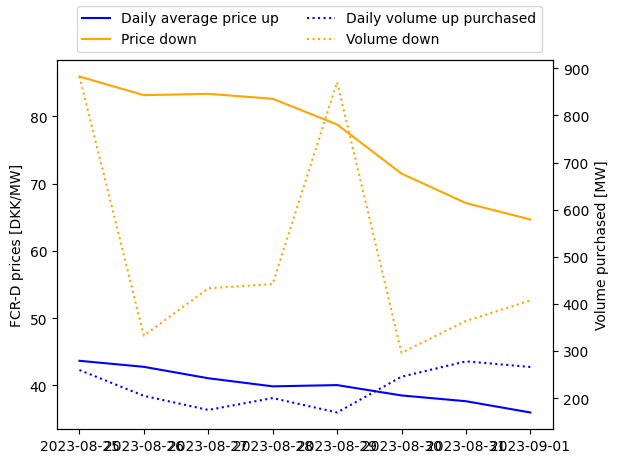

In [120]:
fig, axP = plt.subplots()
axV = plt.twinx(axP)
dataframes = [df_up,df_down,df_volume_up,df_volume_down]
names = ['df_up','df_down','df_volume_up','df_volume_down']
colors = ['blue', 'orange','blue', 'orange']
for df, name, color in zip(dataframes, names, colors): 
    if 'volume' in name: 
        df0 = df.resample('D').sum().copy()
        axV.plot(df0['PurchasedVolumeLocal'], linestyle = ':', color = color)
    else : 
        df0 = df.resample('D').mean().copy()
        axP.plot(df0['PriceTotalEUR'], color = color)
axP.set_ylabel('FCR-D prices [DKK/MW]')
axV.set_ylabel('Volume purchased [MW]')
fig.legend(['Daily average price up', 'Price down', 'Daily volume up purchased', 'Volume down'], ncol=2, loc='upper center')
plt.xticks(rotation = 90)
plt.show()

## Day-ahead forecast for wind and solar generation (from Energidata)

See https://www.energidataservice.dk/tso-electricity/Forecasts_Hour

Get wind and solar forecast from Energidata

Returns 1 pandas dataframe: 'HourDK', 'ForecastType', 'ForecastDayAhead'
df includes solar, wind onshore, wind offshore. 
The forecast is in MWh per hour.

In [121]:
response_data = requests.get(
    url = f'https://api.energidataservice.dk/dataset/Forecasts_Hour?offset=0&start={start_api}&end={end_api}&filter=%7B%22PriceArea%22:[%22'+area_wind+'%22]%7D&sort=HourUTC%20DESC') 
results_data = response_data.json()
records_data = results_data.get('records',[])

df = pd.DataFrame(records_data)
df = df[['HourDK','ForecastType', 'ForecastDayAhead']]
df['HourDK'] = pd.to_datetime(df['HourDK'], format='%Y-%m-%dT%H:%M:%S')
dates = pd.date_range(pd.to_datetime(start_api, format = '%Y-%m-%d'), end = datetime.strptime(end_api, '%Y-%m-%d') + pd.Timedelta(hours = -1), freq = 'H')
df_missing = pd.DataFrame({'HourDK': [pd.to_datetime(dates.difference(df['HourDK'])) for _ in range(3)],
                            'ForecastType': ['Offshore Wind', 'Onshore Wind', 'Solar'],
                            'ForecastDayAhead': [0, 0, 0]})
#df = pd.concat([df,df_missing], ignore_index = True)
print('Original data : \n', df.head())

Original data : 
                HourDK   ForecastType  ForecastDayAhead
0 2023-09-01 23:00:00  Offshore Wind        336.375000
1 2023-09-01 23:00:00   Onshore Wind         75.250000
2 2023-09-01 23:00:00          Solar          0.000000
3 2023-09-01 22:00:00  Offshore Wind        320.500000
4 2023-09-01 22:00:00   Onshore Wind         80.208336


Extracts the wind data and aggregates onshore and offshore

In [122]:

df_wind = pd.concat([df.loc[df['ForecastType'] == 'Offshore Wind'].copy(), df.loc[df['ForecastType'] == 'Onshore Wind'].copy()], ignore_index = True)
df_wind = df_wind[['HourDK', 'ForecastDayAhead', 'ForecastType']]
df_wind = df_wind.rename(columns = {'ForecastDayAhead': 'ForecastDayAhead_Wind'})
print('\nMissing Data (wind): \n',dates.difference(df_wind['HourDK']))
df_missing = pd.DataFrame({'HourDK': [pd.to_datetime(dates.difference(df_wind['HourDK'])) for _ in range(2)],
                            'ForecastType': ['Offshore Wind', 'Onshore Wind'],
                            'ForecastDayAhead_Wind': [0, 0]})
#df_wind = pd.concat([df_wind,df_missing], ignore_index = True)
df_wind = df_wind.groupby('HourDK').sum()
df_wind.index = pd.to_datetime(df_wind.index, format = '%Y-%m-%d %H:%M:%S')
df_wind = df_wind.iloc[::-1]
print('\nWind data : \n ', df_wind.head())



Missing Data (wind): 
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Wind data : 
                       ForecastDayAhead_Wind
HourDK                                    
2023-09-01 23:00:00             411.625000
2023-09-01 22:00:00             400.708336
2023-09-01 21:00:00             369.958336
2023-09-01 20:00:00             343.541676
2023-09-01 19:00:00             364.583344


C:\Users\labeli\AppData\Local\Temp\ipykernel_22872\3071015138.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wind = df_wind.groupby('HourDK').sum()


Extracts the solar data

In [123]:
df_solar = df.loc[df['ForecastType'] == 'Solar'].copy()
df_solar = df_solar[['ForecastDayAhead', 'HourDK']]
df_solar = df_solar.drop_duplicates(subset = 'HourDK')
df_missing = pd.DataFrame({'HourDK': [pd.to_datetime(dates.difference(df_solar['HourDK']))],
                            'ForecastDayAhead': [0]})
#df_solar = pd.concat([df_solar,df_missing], ignore_index = True)
df_solar = df_solar.rename(columns = {'ForecastDayAhead': 'ForecastDayAhead_Solar'})
df_solar = df_solar.set_index('HourDK').sort_index()
df_solar = df_solar.iloc[::-1]
print('\nSolar data : \n ', df_solar.head())


Solar data : 
                       ForecastDayAhead_Solar
HourDK                                     
2023-09-01 23:00:00                0.000000
2023-09-01 22:00:00                0.000000
2023-09-01 21:00:00                0.000000
2023-09-01 20:00:00                1.614167
2023-09-01 19:00:00               33.257084


## Day-ahead forecast for generation and load (from ENTSO-E transparency platform)

Web Api Security Token (key_entso) is provided after creating an account and requesting access to the Restful API (see https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html for creating the API)

in_Domain = EIC codes for Area Y 'DK2', 'DK1' or 'SE4' etc. see https://www.entsoe.eu/data/energy-identification-codes-eic/eic-approved-codes/

Get data for generation from ENTSO transparency platform

In [124]:
start_entso = datetime.strftime(datetime.strptime(start_api, '%Y-%m-%d') + pd.Timedelta(days = 1), format = '%Y%m%d') + '0000'
end_entso = datetime.strftime(datetime.strptime(end, '%Y-%m-%d') + pd.Timedelta(days = 1), format = '%Y%m%d') + '0000'
key_entso = '01db256b-948e-4865-be7a-d9fdbb6875c8'

response_gen = requests.get(url = "https://web-api.tp.entsoe.eu/api?securityToken=" + key_entso + "&documentType=A71&ProcessType=A01&in_Domain=10YDK-2--------M&periodStart="+start_entso+"&periodEnd="+end_entso)
root = ET.fromstring(response_gen.text)
hours = []
generation = []
for time_series in root.findall('.//{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}TimeSeries'):
    for point in time_series.findall('.//{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}Point'):

        # Extract position and quantity data
        position = int(point.find('{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}position').text)
        quantity = int(point.find('{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}quantity').text)

        # Extract day from the time interval
        start_time = time_series.find('.//{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}start').text
        day = start_time.split('T')[0]
        # Calculate hour from position
        hour = (position - 1) % 24  # 0-based index
        
        # Append to lists
        hours.append(day + ' ' + str(hour).zfill(2) + ':00:00')  # Create timestamp in format YYYY-MM-DD HH:00:00
        generation.append(quantity)
data_gen = {'HourDK': hours, 'Generation': generation}

df_gen = pd.DataFrame(data_gen)
dates = pd.date_range(start = pd.to_datetime(start_api), end = datetime.strptime(end_api, '%Y-%m-%d') + pd.Timedelta(hours = -1), freq = 'H')
df_gen = df_gen.drop_duplicates(subset = 'HourDK')
print('Missing Data: \n', dates.difference(df_gen['HourDK']))
missing = dates.difference(df_gen['HourDK'])
df = pd.DataFrame({'HourDK': missing, 'Generation': np.zeros(len(missing))})
df_gen = pd.concat([df_gen, df], ignore_index=True)
df_gen['HourDK'] = pd.to_datetime(df_gen['HourDK'], format='%Y-%m-%d %H:%M:%S')
df_gen = df_gen.set_index('HourDK')
print('\nGeneration Forecast: \n', df_gen.head())


Missing Data: 
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Generation Forecast: 
                      Generation
HourDK                         
2023-08-25 00:00:00       341.0
2023-08-25 01:00:00       361.0
2023-08-25 02:00:00       397.0
2023-08-25 03:00:00       392.0
2023-08-25 04:00:00       404.0


Get data for exogenous variable (load) from ENTSO

In [125]:
response_load = requests.get(url = "https://web-api.tp.entsoe.eu/api?securityToken=" + key_entso + "&documentType=A65&ProcessType=A01&OutBiddingZone_Domain=10YDK-2--------M&periodStart="+start_entso+"&periodEnd="+end_entso)
root = ET.fromstring(response_load.text)
hours = []
load = []
for time_series in root.findall('.//{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}TimeSeries'):
    for point in time_series.findall('.//{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}Point'):

        # Extract position and quantity data
        position = int(point.find('{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}position').text)
        quantity = int(point.find('{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}quantity').text)

        # Extract day from the time interval
        start_time = time_series.find('.//{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0}start').text
        day = start_time.split('T')[0]
        # Calculate hour from position
        hour = (position - 1) % 24  # 0-based index
        
        # Append to lists
        hours.append(day + ' ' + str(hour).zfill(2) + ':00:00')  # Create timestamp in format YYYY-MM-DD HH:00:00
        load.append(quantity)  
data_load = {'HourDK': hours, 'Load': load}

df_load = pd.DataFrame(data_load)
dates = pd.date_range(start = pd.to_datetime(start_api), end = datetime.strptime(end_api, '%Y-%m-%d') + pd.Timedelta(hours = -1), freq = 'H')
df_load = df_load.drop_duplicates(subset = 'HourDK')
# print('Missing Data: ', dates.difference(df_load['HourDK']))
missing = dates.difference(df_load['HourDK'])
df = pd.DataFrame({'HourDK': missing, 'Load': np.zeros(len(missing))})
df_load = pd.concat([df_load,df], ignore_index=True)
df_load['HourDK'] = pd.to_datetime(df_load['HourDK'], format='%Y-%m-%d %H:%M:%S')
df_load = df_load.set_index('HourDK')
print('Load data: \n', df_load.head())


Load data: 
                        Load
HourDK                     
2023-08-25 00:00:00  1159.0
2023-08-25 01:00:00  1118.0
2023-08-25 02:00:00  1091.0
2023-08-25 03:00:00  1080.0
2023-08-25 04:00:00  1114.0


# Preliminary data analysis

Extract the data for prices and exogenous variables for fitting the SARIMAX model.
 
Provide functions for transformation (exponential, log, diff etc.) 

Returns: plot of the hourly data, PACF for the prices, correlation matrix.   

Parameters

In [137]:
start_fit = datetime.strptime(start_api, '%Y-%m-%d')    # (datetime) start for training/fitting the model 
end_fit = datetime.strptime(end,'%Y-%m-%d') + pd.Timedelta(days = +1, hours = -T-1)            # (timestamp) end for training/fitting the model (end of data - T)
dates_train = pd.date_range(start = start_fit, end = end_fit, freq = 'H')

# Service is 'up' or 'down' depending on what FCR-D products to forecast 
service = 'up'

Before fitting the model, it's possible to do transformations on the prices and/or on the exogenous variables (generation, load, wind, solar). Here as examples on the generation data: exponential, log, differenciation, averaging over 1day, box-cox ... 

For example, if the prices have exceptional peaks (like end of november/beginning of december).

To assess if it could improve the model, check the plots, PACF and the correlation matrix first before using it in the auto_arima function.

In [138]:
# df_all = [df_up, df_down, df_gen, df_load, df_solar, df_wind, df_volume_up, df_volume_down]

# Here examples for the FCR-D down prices data: 

# df_down = df_down.ewm(alpha=.05).mean()
# df_down = df_down.apply(lambda x : np.log(x))
# df_down = df_down.diff(periods = -1)
# df_down = df_down.resample('D').mean()

# x = stats.boxcox(df_down['PriceTotalEUR'].to_numpy())
# df_down['PriceTotalEUR'] = x[0]

Select data for fitting the SARIMAX model

Creates pandas dataframe for prices and exogenous variables for training and testing

In [139]:
# Dataframe of prices for fitting the SARIMAX model
prices_train_up = df_up['PriceTotalEUR'][dates_train]
prices_train_down = df_down['PriceTotalEUR'][dates_train]
prices_train_all = pd.DataFrame({'PriceTotalEUR_up' : prices_train_up, 'PriceTotalEUR_down' : prices_train_down})

# Dataframe with all exogenous variables for fittinga the model
exo = pd.concat([df_wind, df_solar, df_gen, df_load], axis=1)
exo = exo.fillna(0)
exo_train = exo.loc[[*dates_train]]

# Dataframe with all data (prices + exo), to use for the correlation matrix
train_data = pd.merge(left = exo_train, right = prices_train_all, left_index = True, right_index = True)
print(train_data.head())

if service == 'up':
    prices_train = prices_train_up
elif service == 'down': 
    prices_train = prices_train_down
print(prices_train)

                     ForecastDayAhead_Wind  ForecastDayAhead_Solar  \
HourDK                                                               
2023-08-25 00:00:00             582.791672                     0.0   
2023-08-25 01:00:00             647.333328                     0.0   
2023-08-25 02:00:00             716.125015                     0.0   
2023-08-25 03:00:00             788.041641                     0.0   
2023-08-25 04:00:00             803.625000                     0.0   

                     Generation    Load  PriceTotalEUR_up  PriceTotalEUR_down  
HourDK                                                                         
2023-08-25 00:00:00       341.0  1159.0          43.75403            90.57656  
2023-08-25 01:00:00       361.0  1118.0          43.65644            90.89995  
2023-08-25 02:00:00       397.0  1091.0          43.61719            90.89734  
2023-08-25 03:00:00       392.0  1080.0          43.53542            90.69236  
2023-08-25 04:00:00       404

Autocorrelation and PACF for the prices

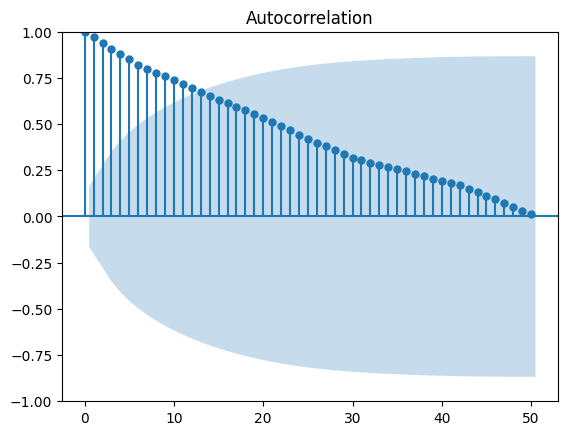

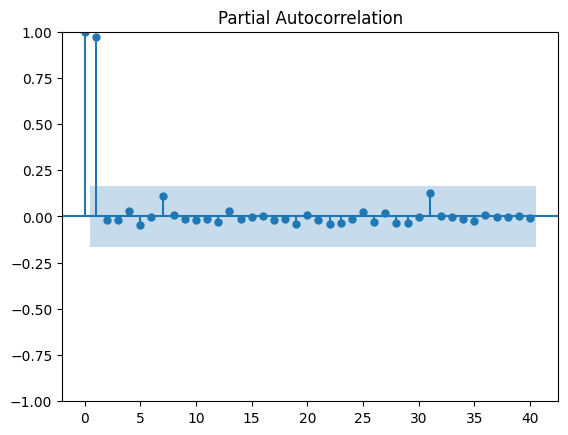

In [140]:
fig1 = sm.graphics.tsa.plot_acf(prices_train.values.squeeze(), lags = 50)
fig2 = sm.graphics.tsa.plot_pacf(prices_train,  lags = 40)
plt.show()

Correlation matrix

In [141]:
print('Correlation matrix: \n', train_data.corr())

Correlation matrix: 
                         ForecastDayAhead_Wind  ForecastDayAhead_Solar  \
ForecastDayAhead_Wind                1.000000                0.136335   
ForecastDayAhead_Solar               0.136335                1.000000   
Generation                          -0.012299                0.750374   
Load                                -0.234668                0.650343   
PriceTotalEUR_up                     0.506675                0.041314   
PriceTotalEUR_down                   0.469373               -0.296909   

                        Generation      Load  PriceTotalEUR_up  \
ForecastDayAhead_Wind    -0.012299 -0.234668          0.506675   
ForecastDayAhead_Solar    0.750374  0.650343          0.041314   
Generation                1.000000  0.509097          0.306210   
Load                      0.509097  1.000000         -0.259410   
PriceTotalEUR_up          0.306210 -0.259410          1.000000   
PriceTotalEUR_down       -0.163236 -0.638998          0.651025   

   

Plot all data available (prices, wind, solar, generation, load)

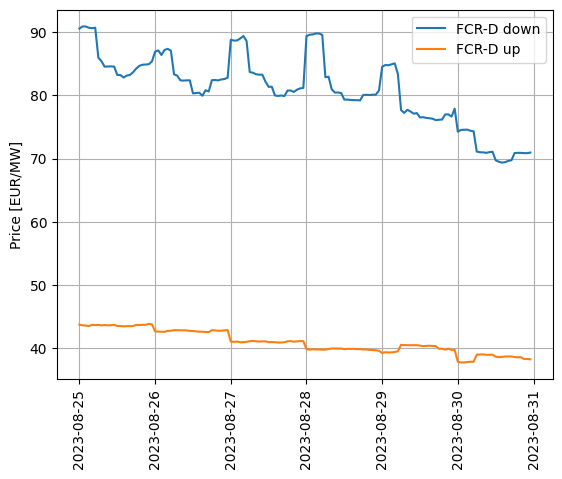

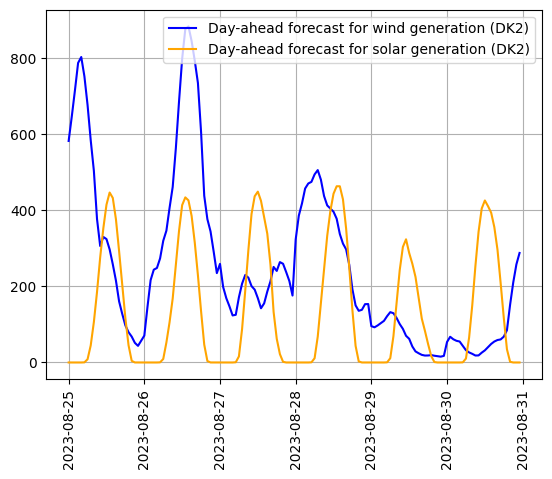

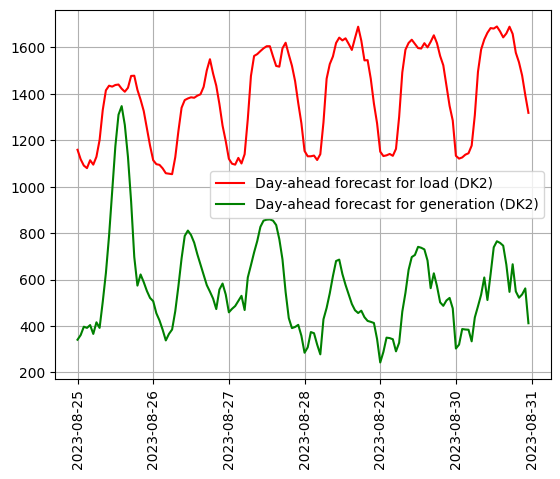

In [142]:
ticks = pd.date_range(start = dates_train[0], end = dates_train[-1] + pd.Timedelta(hours=+1), freq = 'D')

fig, ax = plt.subplots()
for price in [prices_train_down, prices_train_up]:
    ax.plot(dates_train, price)
ax.set_ylabel('Price [EUR/MW]')
plt.grid(visible=True)
plt.xticks(ticks, rotation = 90)
ax.legend(['FCR-D down', 'FCR-D up'])

fig, ax = plt.subplots()
ax.plot(dates_train, train_data['ForecastDayAhead_Wind'], color = 'blue')
ax.plot(dates_train, train_data['ForecastDayAhead_Solar'], color = 'orange')
ax.legend(['Day-ahead forecast for wind generation (DK2)', 'Day-ahead forecast for solar generation (DK2)'])
plt.grid(visible=True)
plt.xticks(ticks, rotation = 90)

fig,ax = plt.subplots()
ax.plot(dates_train, train_data['Load'], color = 'red')
ax.plot(dates_train, train_data['Generation'], color = 'green')
ax.legend(['Day-ahead forecast for load (DK2)', 'Day-ahead forecast for generation (DK2)'])
plt.grid(visible=True)
plt.xticks(ticks, rotation = 90)
plt.show()


# SARIMAX model

If no orders for the model are given, it fits the a SARIMAX model using pmd.auto_arima with a seasonal order of 24.

Returns: the SARIMAX model with its parameters, a forecast for the day 'end' with confidence interval.  

Initializing the model orders

In [143]:
(p,d,q) = (None, None, None)
(P,D,Q,m) = (None, None, None, 24)

Creating and fitting the SARIMAX model

In [144]:
# If the model orders are not known beforehand, use the auto_arima function (can take some time to run...) 
if any(order == None for order in [p,d,q,P,D,Q,m]): 
    arima_model = pmd.auto_arima(prices_train, seasonal=True, m=24, stepwise = True, X = exo_train.to_numpy(), maxiter = 100)
    (p,d,q) = arima_model.order
    (P,D,Q,m) = arima_model.seasonal_order
# If the model orders are known, use the pmd.ARIMA().fit function: 
else : 
    arima_model = pmd.ARIMA(order = (p,d,q), seasonal_order = (P,D,Q,m)).fit(prices_train, X = exo_train.to_numpy(), maxiter= 100)

Print the model orders, parameters, tests and residual diagnostics.

Model parameters:
 intercept   -0.005662
x1          -0.000684
x2          -0.000570
x3          -0.000069
x4           0.001475
ar.S.L24     0.613837
ar.S.L48     0.244122
ma.S.L24    -0.269556
sigma2       0.039327
dtype: float64

Model summary :
                                       SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 24)   Log Likelihood                  18.324
Date:                              Fri, 08 Dec 2023   AIC                            -18.649
Time:                                      14:28:49   BIC                              8.017
Sample:                                  08-25-2023   HQIC                            -7.813
                                       - 08-30-2023                                         
Covariance Type:                                opg                                         
      

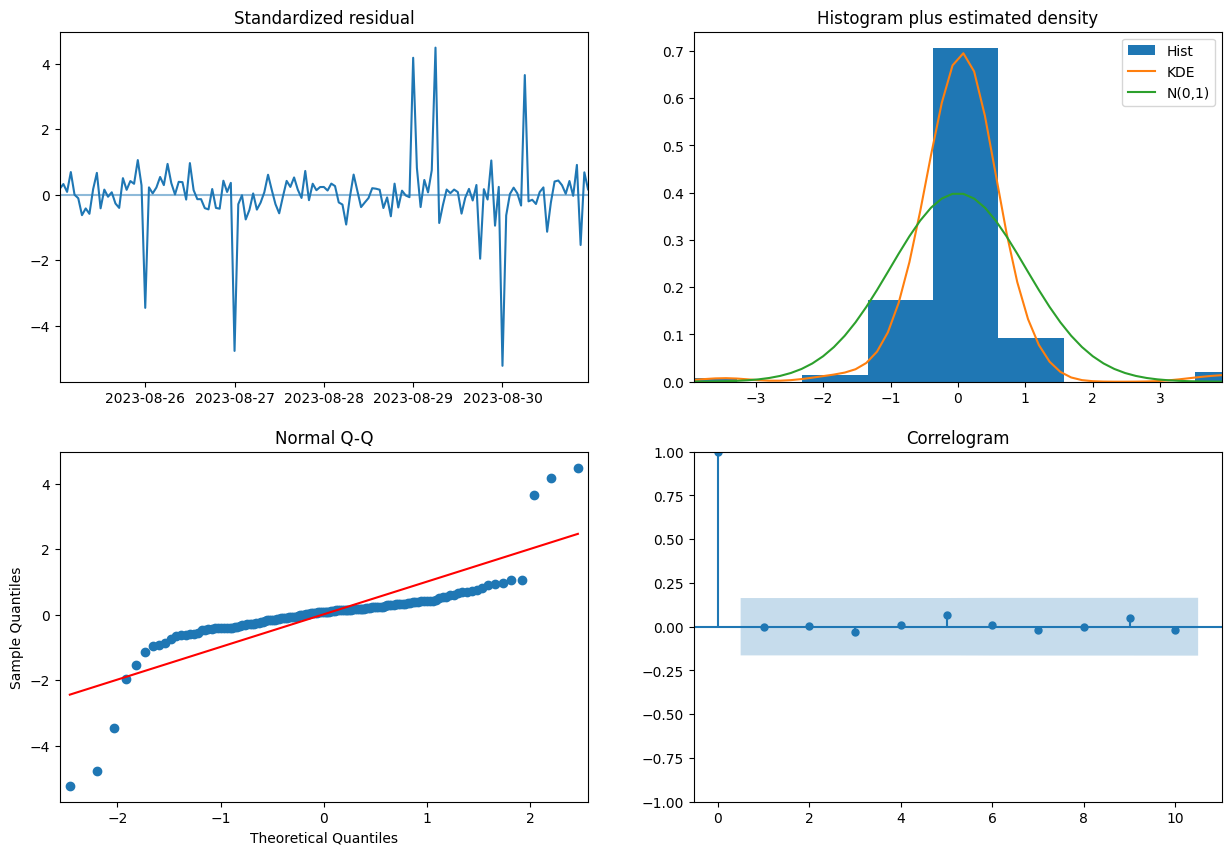

In [145]:
print('Model parameters:\n', arima_model.params())
print('\nModel summary :\n', arima_model.summary())
print('\nModel diagnostics:\n', arima_model.plot_diagnostics(figsize=(15,10)))

Use the SARIMAX model for prices forecast

In [146]:
start_test = datetime.strptime(end, '%Y-%m-%d') + pd.Timedelta(days = +1, hours = -T)
end_test = datetime.strptime(end, '%Y-%m-%d') + pd.Timedelta(days = +1, hours = -1)
dates_test = pd.date_range(start = start_test, end = end_test, freq = 'H')

# Dataframe with prices data for the forecasted day
if service == 'up':
    prices_test = df_up['PriceTotalEUR'][dates_test]
elif service == 'down': 
    prices_test = df_down['PriceTotalEUR'][dates_test]
# Dataframe with all exoenous variables for testing the model
exo_test = exo.loc[dates_test]

pred, conf_int = arima_model.predict(n_periods = T, return_conf_int =  True, alpha = .05, X = exo_test)

Plot prices forecast with confidence interval against the real prices

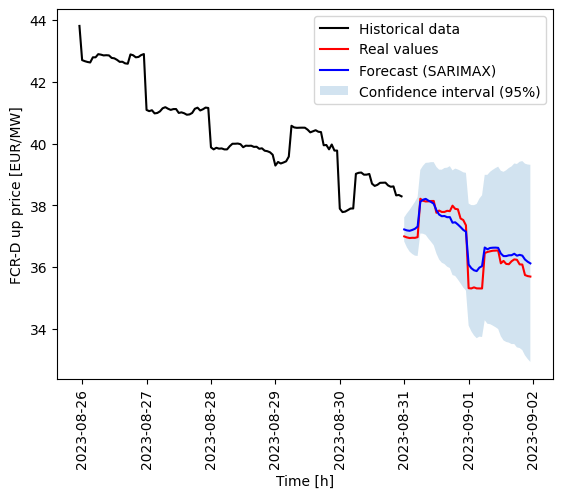

In [155]:
x_data = pd.date_range(datetime.strftime(end_fit + pd.Timedelta(weeks=0, days = -5), '%Y-%m-%d 23:00:00') , datetime.strftime(end_fit, '%Y-%m-%d 23:00:00'), freq='H')
if service == 'up':
    y_data = df_up['PriceTotalEUR'][x_data]
elif service == 'down':
    y_data = df_down['PriceTotalEUR'][x_data]
x_forecast = pd.date_range(end_fit + pd.Timedelta(hours = +1), datetime.strptime(end + ' 23:00:00', '%Y-%m-%d %H:%M:%S'), freq='H')

fig_arima, ax_arima = plt.subplots()
# plot historical data
ax_arima.plot(x_data, y_data, color = 'black')
# plot real prices for that day
ax_arima.plot(x_forecast, prices_test, color = 'red')
# plot 24h pred and CI
ax_arima.plot(x_forecast, pred, color = 'blue')
ax_arima.fill_between(x_forecast, [conf_int[i][0] for i in range(len(conf_int))], [conf_int[i][1] for i in range(len(conf_int))], alpha=0.2)
ax_arima.legend(['Historical data', 'Real values', 'Forecast (SARIMAX)', 'Confidence interval (95%)'])
ax_arima.set_ylabel('FCR-D ' + service +' price [EUR/MW]')
ax_arima.set_xlabel('Time [h]')
plt.xticks(rotation = 90)
plt.show()